In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from rapidfuzz import fuzz
from operator import itemgetter
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
DATA_FOLDER = "../Data/"

actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genres": parse_list,
    },
)

In [193]:
actors = actors_load.copy()
movies = movies_load.copy()

In [194]:
print(actors.shape)
actors.head(100)

(135422, 12)


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...
95,/m/012qgc,Max Schmeling,M,1905-09-28,1.850,Germans,1905.0,"[/m/0bb_0pq, /m/0bf6xp]","{'/m/0bb_0pq': 47.0, '/m/0bf6xp': 64.0}",NaN,NaN,2
96,/m/012rpb,George Dewey,M,1837-12-26,NaN,NaN,1837.0,[/m/0bbr0sm],NaN,NaN,NaN,1
97,/m/012s5j,Raquel Welch,F,1940-09-05,1.680,Bolivian American,1940.0,"[/m/0296vv, /m/02q6hzv, /m/02r1ynz, /m/02r4d_,...","{'/m/0296vv': 60.0, '/m/02q6hzv': 27.0, '/m/02...",NaN,NaN,34
98,/m/012sq7,Richard Simmons,M,1948-07-12,NaN,NaN,1948.0,[/m/051xtx9],{'/m/051xtx9': 50.0},NaN,NaN,1


In [195]:
actors.category[actors.category.notna()].apply(
    lambda d: list(d.values()) if isinstance(d, dict) else []).explode().unique()

array(['ACTOR', 'ACTRESS IN A SUPPORTING ROLE',
       'ACTOR IN A SUPPORTING ROLE', 'ACTOR IN A LEADING ROLE', 'ACTRESS',
       'ACTRESS IN A LEADING ROLE'], dtype=object)

out of 135422 actors, there are 807 unique oscar nominees


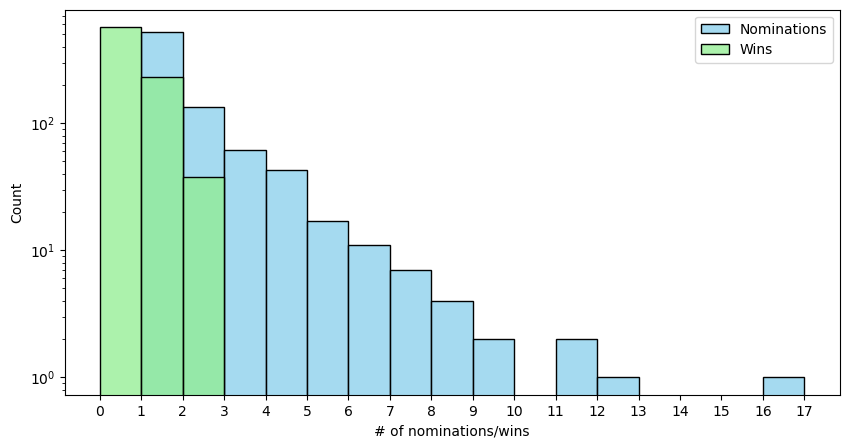

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won
0,/m/010p3,Adam Carolla,M,1964-05-27,1.88,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11,NaN,NaN,False
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,NaN,NaN,False
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.68,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1,NaN,NaN,False
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,NaN,NaN,False
5,/m/011_0k,Jimmy Chamberlin,M,1964-06-10,NaN,NaN,1964.0,[/m/069m37],{'/m/069m37': 29.0},NaN,NaN,1,NaN,NaN,False
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,NaN,NaN,False
7,/m/011_2h,Melissa Auf der Maur,F,1972-03-17,NaN,German Canadian,1972.0,[/m/0fphl7r],{'/m/0fphl7r': 39.0},NaN,NaN,1,NaN,NaN,False
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,1.0,0.0,False
9,/m/011_8,Alex Lifeson,M,1953-08-27,NaN,Serbian Canadians,1953.0,"[/m/03ynwqj, /m/05f9pyv, /m/0fvh98]","{'/m/03ynwqj': 55.0, '/m/05f9pyv': 56.0, '/m/0...",NaN,NaN,3,NaN,NaN,False


In [196]:
# compute actor nominations
actors['nominations'] = actors['category'].dropna().apply(lambda x: len(x))

actors['wins'] = actors['winner'].dropna().apply(lambda x: sum(x.values()))

#actors['nominated'] = actors['nominations'] > 0.0

actors['won'] = actors['wins'] > 0.0

print(f"out of {actors.shape[0]} actors, there are {sum(actors['nominations'] > 0.0)} unique oscar nominees")

plt.figure(figsize=(10, 5))
sns.histplot(actors['nominations'], binwidth=1, log_scale=(False, True), color='skyblue', label='Nominations')
sns.histplot(actors['wins'], binwidth=1, log_scale=(False, True), color='lightgreen', label='Wins')
plt.xlabel('# of nominations/wins')
plt.xticks(np.arange(0, 18, 1))
plt.legend()
plt.show()
actors.head(10)

In [197]:
actors.won.sum()

268

In [198]:
def count_movies_before_first_nomination(winner_dict, age_dict):
    # Sort the movies by age at release
    sorted_movies_by_age = sorted(age_dict.items(), key=lambda item: item[1])

    # Find the first movie where the actor got nominated
    first_nomination_index = next(
        (i for i, (movie_id, _) in enumerate(sorted_movies_by_age) if movie_id in winner_dict), None)

    # If a nomination is found, return the number of movies up to and including the first nomination
    if first_nomination_index is not None:
        return first_nomination_index + 1
    else:
        return np.nan


# Apply the function to each row in the DataFrame
actors['movies_before_first_nomination'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: count_movies_before_first_nomination(x['winner'], x['ageAtMovieRelease']), axis=1)
actors.movies_before_first_nomination.dropna().value_counts()

movies_before_first_nomination
1.0     81
2.0     63
3.0     58
4.0     45
7.0     38
        ..
56.0     1
82.0     1
53.0     1
54.0     1
59.0     1
Name: count, Length: 56, dtype: int64

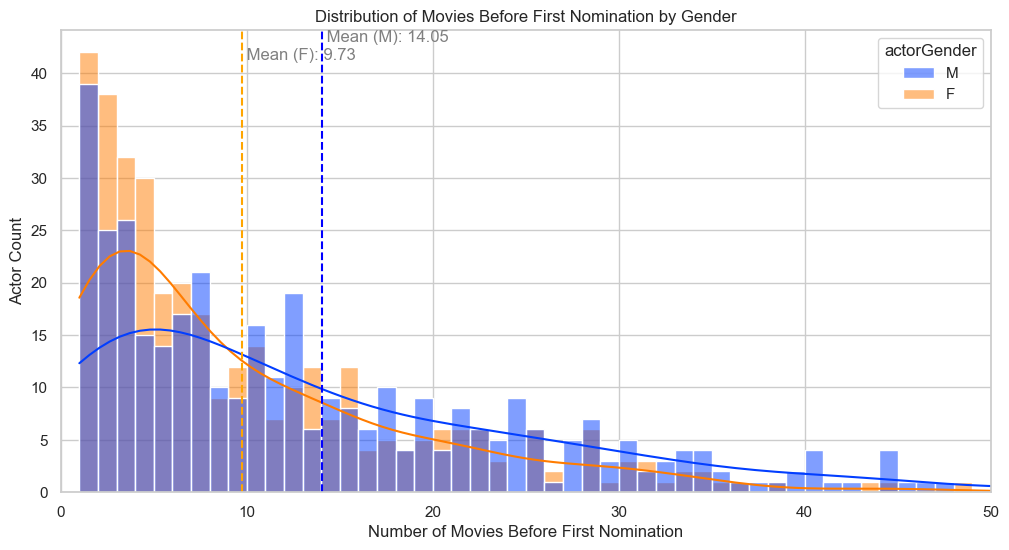

In [199]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the histogram plot
plt.figure(figsize=(12, 6))
plt.xlim(0, 50)
ax = sns.histplot(data=actors, x='movies_before_first_nomination', hue='actorGender', binwidth=1, kde=True, element='bars',
                  multiple='layer', palette='bright', legend=True)

# Calculate mean values for each gender and add them to the plot
mean_values = actors.groupby('actorGender')['movies_before_first_nomination'].mean()
plt.axvline(x=mean_values['M'], linestyle='--', color='blue')
plt.text(mean_values['M'], plt.ylim()[1], f' Mean (M): {mean_values["M"]:.2f}', color='grey', ha='left', va='top')
plt.axvline(x=mean_values['F'], linestyle='--', color='orange')
plt.text(mean_values['F'], plt.ylim()[1], f'\n Mean (F): {mean_values["F"]:.2f}', color='grey', ha='left', va='top')

# Adding plot title and labels
plt.title('Distribution of Movies Before First Nomination by Gender')
plt.xlabel('Number of Movies Before First Nomination')
plt.ylabel('Actor Count')

# Show the plot
plt.show()


**Yes, actors and actresses compete in different categories at the Oscars. The categories are divided based on gender: Actor in a Leading Role and Actor in a Supporting Role for male actors, and Actress in a Leading Role and Actress in a Supporting Role for female actresses. This separation ensures gender-specific recognition within the acting field. Each category typically has an equal number of nominees, maintaining a balance between male and female acting nominees.**

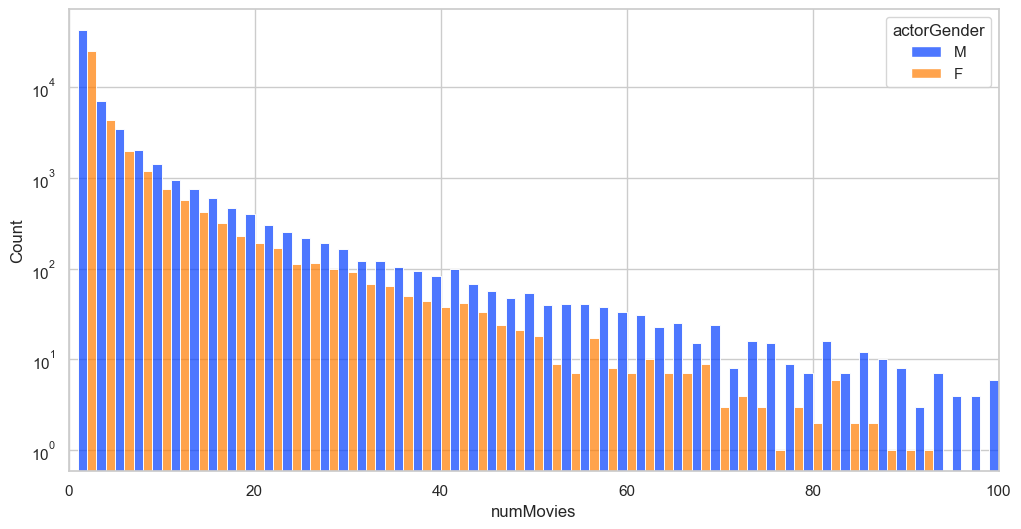

0.45426149370117114
0.2648166472212787


In [200]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")


# Create the histogram plot
plt.figure(figsize=(12, 6))
plt.xlim(0, 100)
sns.histplot(data=actors, x='numMovies', hue='actorGender', binwidth=2, element='bars', multiple='dodge',
             palette='bright', alpha=0.7, legend=True)
plt.yscale('log')
plt.show()

#actors.dropna(subset='actorGender', inplace=True)
print(len(actors[actors['actorGender'] == 'M']) / len(actors))
print(len(actors[actors['actorGender'] == 'F']) / len(actors))

In [201]:
ttest_ind(actors[actors['actorGender'] == 'M']['movies_before_first_nomination'].dropna(),
          actors[actors['actorGender'] == 'F']['movies_before_first_nomination'].dropna())

TtestResult(statistic=4.891522301581658, pvalue=1.2337101872284636e-06, df=724.0)

In [202]:
def count_nominations_before_first_win(winner_dict, age_dict):
    nominated_years = {movie_id: age_dict[movie_id] for movie_id in winner_dict if movie_id in age_dict}

    first_win_age = min(
        (nominated_years[movie_id] for movie_id, won in winner_dict.items() if won and movie_id in nominated_years),
        default=None)

    if first_win_age is not None:
        return sum(1 for age in nominated_years.values() if age <= first_win_age)
    else:
        return np.nan


actors['nominations_before_first_win'] = actors.dropna(subset=('winner', 'ageAtMovieRelease')).apply(
    lambda x: count_nominations_before_first_win(x['winner'], x['ageAtMovieRelease']), axis=1)
print(actors.nominations_before_first_win.dropna().shape[0])
actors.nominations_before_first_win.value_counts()
#actors[actors.nominations_before_first_win == 1.0]

239


nominations_before_first_win
1.0    146
2.0     56
3.0     21
4.0      9
6.0      2
5.0      2
7.0      2
9.0      1
Name: count, dtype: int64

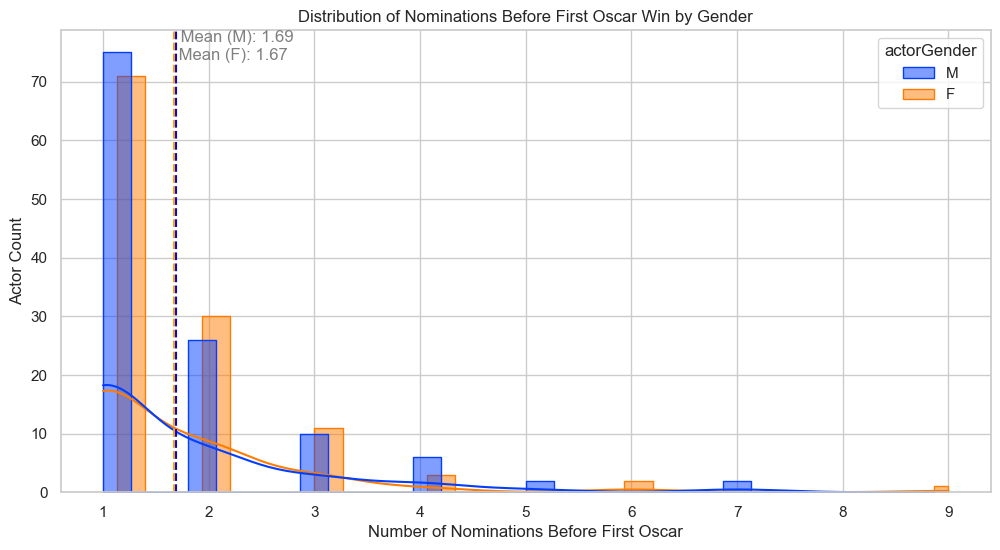

In [203]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the histogram plot
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=actors, x='nominations_before_first_win', hue='actorGender', bins=30, kde=True, element='step',
                  multiple='dodge', palette='bright', legend=True)

mean_values = actors.groupby('actorGender')['nominations_before_first_win'].mean()
plt.axvline(x=mean_values['M'], linestyle='--', color='blue', label='mean')
plt.text(mean_values['M'], plt.ylim()[1], f' Mean (M): {mean_values["M"]:.2f}', color='grey', ha='left', va='top')
plt.axvline(x=mean_values['F'], linestyle='--', color='orange', label='mean')
plt.text(mean_values['F'], plt.ylim()[1], f'\n Mean (F): {mean_values["F"]:.2f}', color='grey', ha='left', va='top')

# Adding plot title and labels
plt.title('Distribution of Nominations Before First Oscar Win by Gender')
plt.xlabel('Number of Nominations Before First Oscar')
plt.ylabel('Actor Count')

# Show the plot
plt.show()

In [204]:
ttest_ind(actors[actors['actorGender'] == 'M']['nominations_before_first_win'].dropna(),
          actors[actors['actorGender'] == 'F']['nominations_before_first_win'].dropna())

TtestResult(statistic=0.16248539661620617, pvalue=0.8710620781594355, df=237.0)

<Axes: >

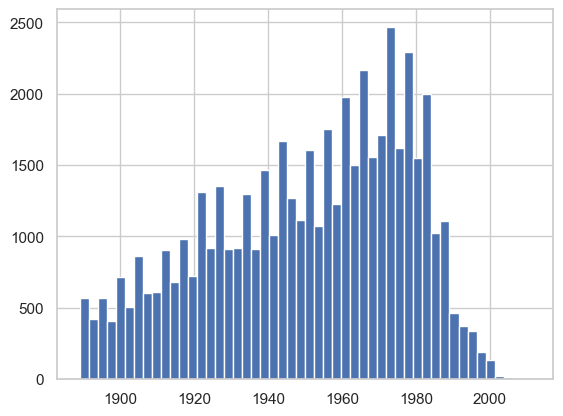

In [205]:
actors[actors.yearOfBirth > 1888].yearOfBirth.hist(bins=50)

In [206]:
# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan


def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


actors_after_1888 = actors[actors['yearOfBirth'] > 1888.0]
# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)

actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < movies['releaseYear'].max() - 61]
# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

display(actors_full_career)
print(
    f"Keeping only actors with a full career, we have {actors_full_career.shape[0]} actors, of which there are {sum(actors_full_career['nominations'] > 0.0)} unique oscar nominees")

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,movies_before_first_nomination,nominations_before_first_win,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,NaN,NaN,False,NaN,NaN,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,NaN,NaN,False,NaN,NaN,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,NaN,NaN,False,NaN,NaN,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,1.0,0.0,False,NaN,NaN,37.0,69.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135413,/m/0ywqc,Donald Sutherland,M,1935-07-17,1.93,NaN,1935.0,"[/m/01_jty, /m/01cbx, /m/01gm5j, /m/01sy99, /m...","{'/m/01_jty': 59.0, '/m/01cbx': 57.0, '/m/01gm...",NaN,NaN,111,NaN,NaN,False,NaN,NaN,29.0,76.0,47.0
135414,/m/0yxl,Alan Moore,M,1953-11-18,NaN,NaN,1953.0,[/m/0c7qn5],{'/m/0c7qn5': 49.0},NaN,NaN,1,NaN,NaN,False,NaN,NaN,49.0,49.0,0.0
135415,/m/0z05l,Graham Greene,M,1952-06-22,1.79,First Nations,1952.0,"[/m/01_1hw, /m/021jdm, /m/02748ds, /m/02rtv28,...","{'/m/01_1hw': 42.0, '/m/021jdm': 41.0, '/m/027...",{'/m/0y_9q': 'ACTOR IN A SUPPORTING ROLE'},{'/m/0y_9q': False},27,1.0,0.0,False,3.0,NaN,31.0,58.0,27.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,"[/m/012y5v, /m/016z5x, /m/016z9n, /m/018tmf, /...","{'/m/012y5v': 46.0, '/m/016z5x': 54.0, '/m/016...","{'/m/016z9n': 'ACTOR IN A LEADING ROLE', '/m/0...","{'/m/016z9n': False, '/m/0260bz': False, '/m/0...",80,4.0,1.0,True,32.0,1.0,29.0,76.0,47.0


Keeping only actors with a full career, we have 25344 actors, of which there are 586 unique oscar nominees


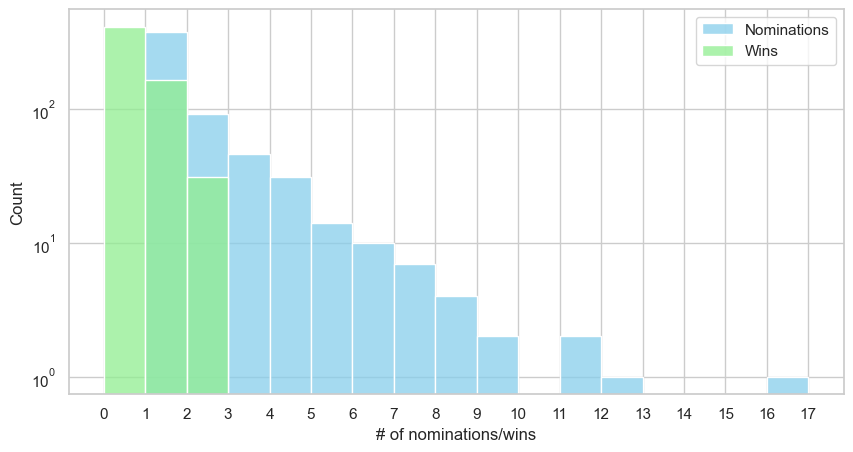

In [207]:
plt.figure(figsize=(10, 5))
sns.histplot(actors_full_career['nominations'], binwidth=1, log_scale=(False, True), color='skyblue',
             label='Nominations')
sns.histplot(actors_full_career['wins'], binwidth=1, log_scale=(False, True), color='lightgreen', label='Wins')
plt.xlabel('# of nominations/wins')
plt.xticks(np.arange(0, 18, 1))
plt.legend()
plt.show()
# exponential decay

In [208]:
print(
    f"there are {sum(actors_full_career.dropna(subset='actorEthnicity')['nominations'] > 0.0)} unique oscar nominees with ethnicity information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('careerLength'))['nominations'] > 0.0)} unique oscar nominees with career length information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('actorHeight'))['nominations'] > 0.0)} unique oscar nominees with height information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('careerLength', 'actorHeight'))['nominations'] > 0.0)} unique oscar nominees with height and career length information")

there are 133 unique oscar nominees with ethnicity information
there are 528 unique oscar nominees with career length information
there are 440 unique oscar nominees with height information
there are 415 unique oscar nominees with height and career length information


considering 415 actors

Logistic Regression results over 10 folds
Accuracy: 0.720 ± 0.099
F1 Score: 0.657 ± 0.121


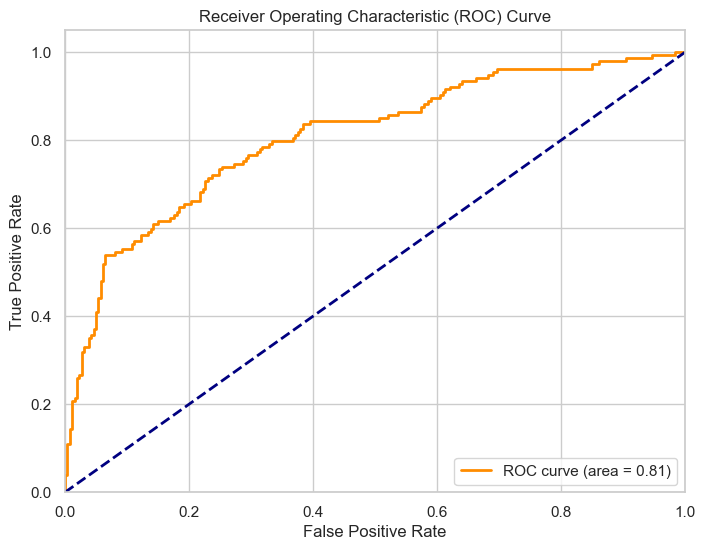

Best Threshold: 0.308, G-Mean: 0.744

On whole dataset:
Accuracy: 0.742
F1 score: 0.679

Baseline - random Guess F1 Score: 0.360


,actorGender,actorHeight,numMovies,ageAtFirstMovie,careerLength,nominations,won,propensityScore_sk
3,M,1.850,52,28.0,44.0,1.0,False,0.237514
8,F,1.730,27,37.0,32.0,1.0,False,0.243919
38,M,1.770,21,25.0,45.0,1.0,False,0.207113
61,M,1.750,28,25.0,25.0,1.0,False,0.105597
65,F,1.626,38,17.0,59.0,1.0,False,0.305219
...,...,...,...,...,...,...,...,...
135322,M,1.750,11,25.0,8.0,1.0,False,0.058155
135331,M,1.840,43,26.0,31.0,6.0,True,0.876220
135392,M,1.778,37,35.0,40.0,3.0,True,0.557817
135415,M,1.790,27,31.0,27.0,1.0,False,0.138237


In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

actors_oscars = actors_full_career[
    ['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'careerLength', 'nominations', 'won']].dropna()
print(f"considering {actors_oscars.shape[0]} actors\n")

# Selecting columns for the analysis
X = actors_oscars[['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'nominations', 'careerLength']]
y = actors_oscars['won']

# Preprocessing: Encoding categorical variables and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['actorHeight', 'numMovies', 'ageAtFirstMovie', 'nominations', 'careerLength']),
        ('cat', OneHotEncoder(), ['actorGender'])
    ])

# Logistic Regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Define the K-Fold cross-validation
k_folds = 10
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=17)


def custom_evaluation(model, X_test, y_test, threshold=0.5):
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]
    # Apply threshold to determine class predictions
    preds = (probs >= threshold).astype(int)
    # Calculate desired metrics
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return acc, f1


# Initialize lists to store metrics for each fold
acc_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    acc, f1 = custom_evaluation(model, X_test, y_test, threshold=0.3)
    acc_scores.append(acc)
    f1_scores.append(f1)

print(f"Logistic Regression results over {k_folds} folds")
print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

# Fit the model to the entire dataset
model.fit(X, y)

# Compute predicted probabilities
predicted_probabilities = model.predict_proba(X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1 - fpr))
# Locate the index of the largest G-mean, i.e. best threshold in the Youden's J statistic sense
ix = np.argmax(gmeans)
print(f'Best Threshold: {thresholds[ix]:.3f}, G-Mean: {gmeans[ix]:.3f}')

print(f"\nOn whole dataset:\nAccuracy: {accuracy_score(y, predicted_probabilities > thresholds[ix]):.3f}")
print(f"F1 score: {f1_score(y, predicted_probabilities > thresholds[ix]):.3f}")

# Generate random predictions that match the class distribution
unique, counts = np.unique(y, return_counts=True)
class_distribution = counts / counts.sum()
random_predictions = np.random.choice(unique, size=len(y), p=class_distribution)
# Calculate the F1 score for these random predictions
random_f1 = f1_score(y, random_predictions)
print(f"\nBaseline - random Guess F1 Score: {random_f1:.3f}")

# If you need to attach these scores back to your original DataFrame
actors_oscars['propensityScore_sk'] = predicted_probabilities
actors_oscars

In [210]:
import statsmodels.formula.api as smf

standardize = lambda x: (x - x.mean()) / x.std()

actors_full_career.nominations.fillna(0.0, inplace=True)
actors_oscars = actors_full_career[
    ['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'careerLength', 'nominations', 'won']].dropna()
print(f"considering {actors_oscars.shape[0]} actors\n")

# statsmodels has trouble with boolean values..
actors_oscars['won'] = actors_oscars['won'].astype(int)

# standardize the continuous features
actors_oscars['actorHeight'] = standardize(actors_oscars['actorHeight'])
actors_oscars['numMovies'] = standardize(actors_oscars['numMovies'])
actors_oscars['ageAtFirstMovie'] = standardize(actors_oscars['ageAtFirstMovie'])
actors_oscars['nominations'] = standardize(actors_oscars['nominations'])
actors_oscars['careerLength'] = standardize(actors_oscars['careerLength'])

model = smf.logit(
    formula='won ~ C(actorGender) + actorHeight + numMovies + ageAtFirstMovie + careerLength + nominations',
    data=actors_oscars)

res = model.fit()

# extract the estimated propensity scores
actors_oscars['propensityScore_sm'] = res.predict()

print(res.summary())

# Exponentiating the coefficients to get odds ratios
odds_ratios = np.exp(res.params)
print(f"Odd ratios:\n{odds_ratios})")

actors_oscars

considering 3451 actors

Optimization terminated successfully.
         Current function value: 0.081320
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    won   No. Observations:                 3451
Model:                          Logit   Df Residuals:                     3444
Method:                           MLE   Df Model:                            6
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.5584
Time:                        16:01:18   Log-Likelihood:                -280.63
converged:                       True   LL-Null:                       -635.48
Covariance Type:            nonrobust   LLR p-value:                4.925e-150
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.2104      0.286    -14.706      0.000  

,actorGender,actorHeight,numMovies,ageAtFirstMovie,careerLength,nominations,won,propensityScore_sm
3,M,0.851955,1.442772,-0.238940,1.051332,0.783101,0,0.084713
4,M,-0.089194,1.266762,-0.238940,0.879471,-0.263156,0,0.014428
8,F,-0.174753,0.342711,0.502221,0.363890,0.783101,0,0.073978
19,M,0.424160,-0.449332,0.255167,0.936758,-0.263156,0,0.014977
20,M,0.253042,-0.273322,-0.238940,-0.724559,-0.263156,0,0.002479
...,...,...,...,...,...,...,...,...
135406,F,-0.850669,-0.713347,1.737489,-1.125567,-0.263156,0,0.004654
135411,M,0.851955,-0.757349,0.008113,0.994045,-0.263156,0,0.014852
135413,M,1.536426,4.038914,-0.156589,1.223192,-0.263156,0,0.038984
135415,M,0.338601,0.342711,0.008113,0.077456,0.783101,0,0.029179


In [211]:
from scipy import stats

correlation, p_value = stats.pointbiserialr(actors_oscars['actorGender'].map({'M': 1, 'F': 0}),
                                            actors_oscars['nominations'])
print(f"Point-Biserial Correlation: {correlation}, P-value: {p_value}")
# statistically significant negative correlation between actor gender being male and number of nominations

Point-Biserial Correlation: -0.06700947286465708, P-value: 8.165572223398323e-05


In [212]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1 - np.abs(propensity_score1 - propensity_score2)

In [213]:
actors_oscars.shape

(3451, 8)

In [214]:
explode_on_movies(actors_full_career)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,movies_before_first_nomination,nominations_before_first_win,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,/m/033pf1,67.0,NaN,NaN,1,0.0,NaN,False,NaN,NaN,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/015gl2,NaN,ACTOR,False,52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0273r02,68.0,None,None,52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/02qf1bq,36.0,None,None,52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/02qf7sl,64.0,None,None,52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0kv238,72.0,None,None,80,4.0,1.0,True,32.0,1.0,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0kv36n,69.0,None,None,80,4.0,1.0,True,32.0,1.0,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0m9p3,39.0,None,None,80,4.0,1.0,True,32.0,1.0,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0qmd5,42.0,None,None,80,4.0,1.0,True,32.0,1.0,29.0,76.0,47.0


In [215]:
actors_full_career.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,movies_before_first_nomination,nominations_before_first_win,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,0.0,NaN,False,NaN,NaN,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False,NaN,NaN,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,0.0,NaN,False,NaN,NaN,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,0.0,NaN,False,NaN,NaN,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,1.0,0.0,False,NaN,NaN,37.0,69.0,32.0


In [216]:
# standardize the continuous features
actors_full_career['actorHeight'] = standardize(actors_full_career['actorHeight'])
actors_full_career['numMovies'] = standardize(actors_full_career['numMovies'])
actors_full_career['ageAtFirstMovie'] = standardize(actors_full_career['ageAtFirstMovie'])
actors_full_career['ageAtLastMovie'] = standardize(actors_full_career['ageAtLastMovie'])
actors_full_career['nominations'] = standardize(actors_full_career['nominations'])
actors_full_career['careerLength'] = standardize(actors_full_career['careerLength'])

actors_full_career['nominated'] = actors_full_career['nominations'] > 0.0
# statsmodels has trouble with boolean values..
actors_full_career['nominated'] = actors_full_career['nominated'].astype(int)

model = smf.logit(
    formula='nominated ~ C(actorGender) + numMovies + ageAtFirstMovie + careerLength', data=actors_full_career)
# actorHeight +
res = model.fit()

print(res.summary())
# Exponentiating the coefficients to get odds ratios
odds_ratios = np.exp(res.params)
print(f"Odd ratios:\n{odds_ratios})")

model = smf.ols(
    formula='nominations ~ C(actorGender) + actorHeight + numMovies + ageAtFirstMovie + careerLength',
    data=actors_full_career)
# actorHeight +
res = model.fit()

print(res.summary())


Optimization terminated successfully.
         Current function value: 0.078174
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              nominated   No. Observations:                22027
Model:                          Logit   Df Residuals:                    22022
Method:                           MLE   Df Model:                            4
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3089
Time:                        16:01:20   Log-Likelihood:                -1721.9
converged:                       True   LL-Null:                       -2491.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.1367      0.094    -44.231      0.000      -4.320      -3.953
C(

In [217]:
actors_nominations = actors.dropna(subset=('nominations', 'winner', 'ageAtMovieRelease', 'actorGender'))  #_full_career
print(f"unique nominations: {actors_nominations.shape[0]}"
      f"\ntotal nominations: {sum(actors_nominations['nominations']):.0f}")

unique nominations: 716
total nominations: 1309


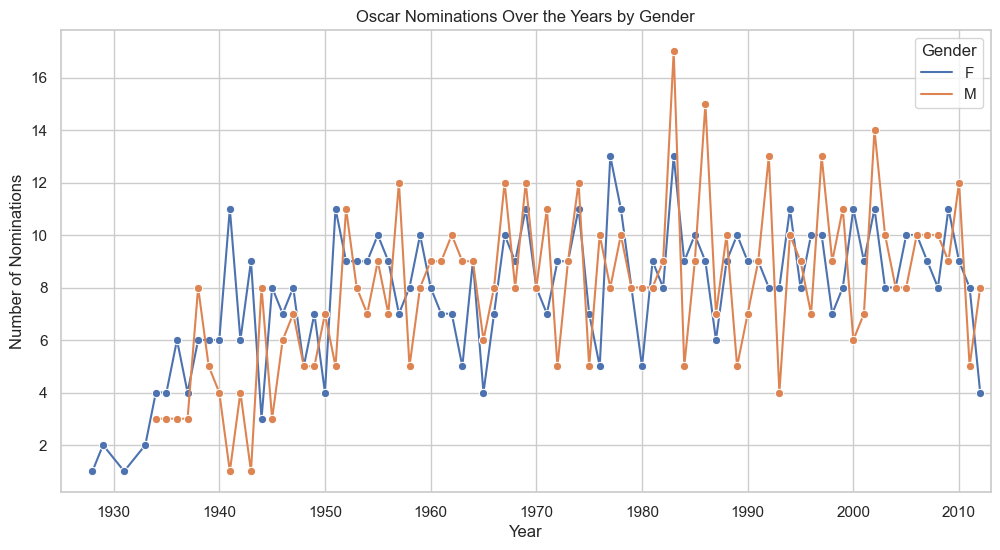

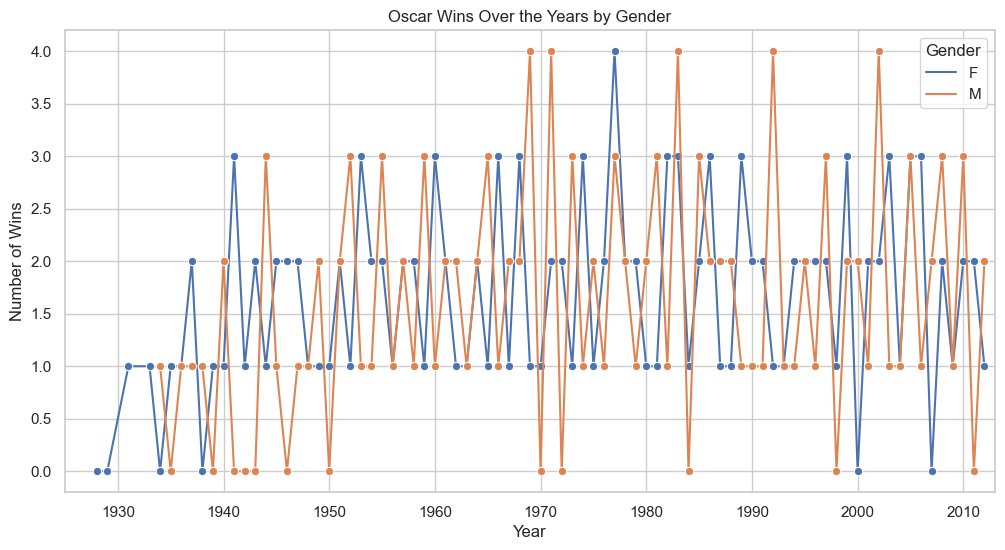

,Year,totalNominations,Gender,totalNominationsPerGender,proportionNominations
0,1928.0,1,F,1,1.000000
1,1929.0,2,F,2,1.000000
2,1931.0,1,F,1,1.000000
3,1933.0,2,F,2,1.000000
4,1934.0,7,F,4,0.571429
...,...,...,...,...,...
157,2010.0,21,M,12,0.571429
158,2011.0,13,F,8,0.615385
159,2011.0,13,M,5,0.384615
160,2012.0,12,F,4,0.333333


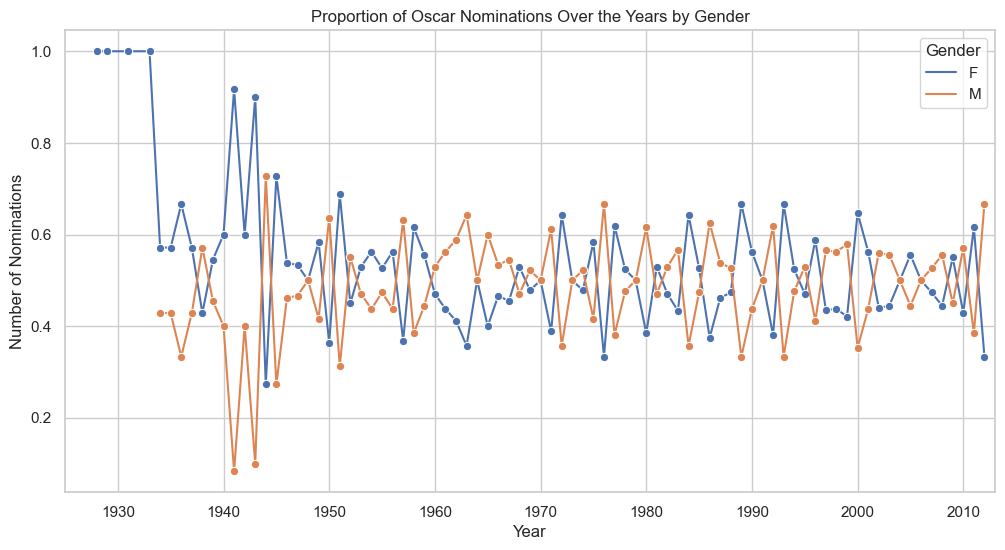

In [218]:
# Function to calculate the year of movie release
def calculate_year_of_release(birth_year, age_at_release):
    return birth_year + age_at_release


# Expand the dictionaries into a DataFrame
rows = []
for i, row in actors_nominations.iterrows():
    for movie_id, age in row['ageAtMovieRelease'].items():
        year_of_release = calculate_year_of_release(row['yearOfBirth'], age)
        won_oscar = row['winner'].get(movie_id, np.nan)
        rows.append({'Year': year_of_release, 'WonOscar': won_oscar, 'Gender': row['actorGender']})

expanded_df = pd.DataFrame(rows).dropna(subset='WonOscar')

# Count the number of nominations per year by gender
nomination_counts = expanded_df.groupby(['Year', 'Gender']).size().reset_index(name='Nominations')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=nomination_counts, x='Year', y='Nominations', hue='Gender', marker='o')

plt.title('Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.xlim(1925, 2013)
plt.show()

# Count the number of nominations per year by gender
win_counts = expanded_df.groupby(['Year', 'Gender'])['WonOscar'].sum().reset_index(name='Wins')*1
# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=win_counts, x='Year', y='Wins', hue='Gender', marker='o')

plt.title('Oscar Wins Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.xlim(1925, 2013)
plt.show()

nominations_per_year_gender = expanded_df.groupby(['Year', 'Gender']).size().reset_index(
    name='totalNominationsPerGender')
nominations_per_year = expanded_df.groupby('Year').size().reset_index(name='totalNominations')

merged_df = pd.merge(nominations_per_year, nominations_per_year_gender, on='Year')
merged_df['proportionNominations'] = merged_df['totalNominationsPerGender'] / merged_df['totalNominations']
display(merged_df)

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='proportionNominations', hue='Gender', marker='o')

plt.title('Proportion of Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.xlim(1925, 2013)
plt.show()

**en fait chaque année y'a 5 nominations pour chaque catégorie et 1 winner par catégorie, donc on voit juste du jitter parce qu'on a pas les années exactes de nomination**

## tldr: ces plots sont useless :))

In [219]:
expanded_df[expanded_df['WonOscar'] == True]

,Year,WonOscar,Gender
320,1952.0,True,M
379,1997.0,True,M
609,2002.0,True,F
637,1969.0,True,M
813,1979.0,True,F
...,...,...,...
25108,1988.0,True,M
25199,1949.0,True,M
25213,2002.0,True,M
25222,2008.0,True,M


In [220]:
from scipy.stats import ttest_ind

ttest_ind(nomination_counts[nomination_counts['Gender'] == 'M']['Nominations'],
          nomination_counts[nomination_counts['Gender'] == 'F']['Nominations'])

TtestResult(statistic=0.2910162559979314, pvalue=0.7714157886557006, df=160.0)

<Figure size 1200x600 with 0 Axes>

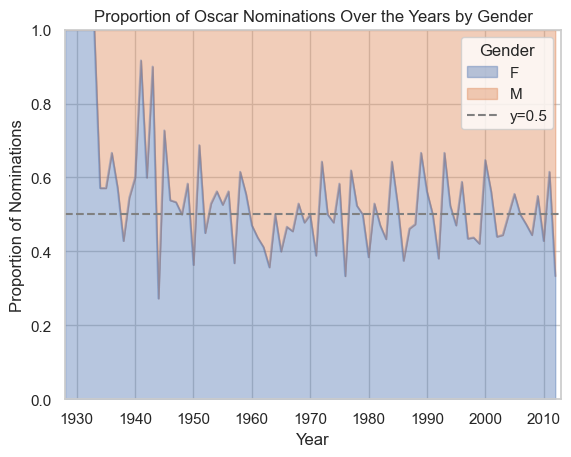

In [221]:
# pivot dataframe to get years as the index and genders as columns
pivot_df = merged_df.pivot(index='Year', columns='Gender', values='proportionNominations')

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='area', stacked=True, alpha=0.4)

plt.title('Proportion of Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Proportion of Nominations')
plt.xlim(1928, 2013)
plt.ylim(0, 1)
plt.axhline(y=0.5, linestyle='--', color='grey', label='y=0.5')
plt.legend(title='Gender')
plt.show()


In [222]:
actors_full_career.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,...,numMovies,nominations,wins,won,movies_before_first_nomination,nominations_before_first_win,ageAtFirstMovie,ageAtLastMovie,careerLength,nominated
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,...,-0.453841,-0.112947,NaN,False,NaN,NaN,2.185446,1.048968,-0.866487,0
3,/m/010xjr,Richard Harris,M,1930-10-01,0.866175,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},...,3.393659,2.486982,0.0,False,NaN,NaN,-0.544524,1.344235,1.966442,1
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,-0.075277,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,...,3.091894,-0.112947,NaN,False,NaN,NaN,-0.544524,1.167075,1.773288,0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,...,-0.378399,-0.112947,NaN,False,NaN,NaN,-0.404525,0.045061,0.421208,0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,-0.160864,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},...,1.507630,2.486982,0.0,False,NaN,NaN,0.085469,1.167075,1.193825,1
